In [17]:
#database final.sqlite is created after cleaning the amazon food reviews data

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score,f1_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.metrics import classification_report 
from sklearn import cross_validation
import sqlite3
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable
from scipy import stats
x = PrettyTable()

con=sqlite3.connect("final.sqlite")

# time based sorting
clean_reviews=pd.read_sql_query(""" Select * from Reviews Order By Time""" , con)
clean_reviews=clean_reviews[:1000]

cleaned_text=clean_reviews['CleanedText'].values
score=clean_reviews['Score']
score.value_counts()


positive    923
negative     77
Name: Score, dtype: int64

This is an unbalanced dataset

In [18]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorization", "Model","Regularization" ,"C", "f1 score"]

This is an unblanced dataset

#Featurization using Bag of Words and model using kNN for classification of review

In [22]:
#Featurization using BoW

from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer()#max_features=300)
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(cleaned_text,score,test_size=0.3,random_state=0)
training_set_transformed=count_vect.fit_transform(x_tr)



In [23]:
svd = TruncatedSVD(n_components=3000, n_iter=7, random_state=42)
s=svd.fit_transform(training_set_transformed)
no_of_features=np.array([100,200,300,500,1000,1500,2000,3000])
variances=[]
for i in no_of_features:
    variances.append(np.sum(svd.explained_variance_ratio_[:i]))

Text(0.5,1,'no_of_features vs variances')

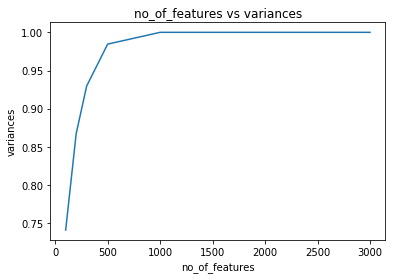

In [24]:
plt.plot(no_of_features,variances)
plt.xlabel("no_of_features")
plt.ylabel("variances")
plt.title("no_of_features vs variances")

The plot shows that 80% of variance is covered with 1000 features

In [25]:
#variance with 300 features
np.sum(svd.explained_variance_ratio_[:300])

0.9296391898730635

This is good amount of information : not much data is lost
Therefore taking 300 feAtures for this exercise

In [26]:
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
final_counts=svd.fit_transform(training_set_transformed)
final_counts=preprocessing.scale(final_counts)
type(final_counts)
final_counts.shape
type(x_test)

numpy.ndarray

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(final_counts, i) for i in range(final_counts.shape[1])]
sorted_vif=sorted(vif)
no_duplicates=set(sorted_vif)
for i in no_duplicates:
    if i >5 :
         np.delete(final_counts,vif.index(i),axis=1)

In [ ]:
x_test=count_vect.transform(x_test)
x_test=svd.transform(x_test)
x_test=preprocessing.scale(x_test)

In [28]:
#Logistic Regression with 3 fold CV with GridSearch and Randomized Search
#x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(final_counts,score,test_size=0.3,random_state=0)
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
custom_scorer=make_scorer(f1_score,pos_label="positive")



In [29]:
#Using GridSearchCV and L2 regularization
model = GridSearchCV(LogisticRegression(class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
x_test.shape

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


(300,)

In [30]:

print(model.score(x_test, y_test))
print (model.best_params_["C"])

0.9637305699481865
100


In [31]:
x.add_row(["BoW","Logistic Regression GridSearchCV","L2",model.best_params_["C"],model.score(x_test, y_test)])


In [32]:
#Using GridSearchCV and L1 regularization
model = GridSearchCV(LogisticRegression(penalty='l1',class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
#x_test=count_vect.transform(x_test)

print(model.score(x_test, y_test))
x.add_row(["BoW","Logistic Regression GridSearchCV","L1",model.best_params_["C"],model.score(x_test, y_test)])


LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9637305699481865


In [33]:
#Using RandomizedSearchCV and L2 regularization
tuned_parameters = {"C": stats.uniform(2, 10)}
custom_scorer=make_scorer(f1_score,pos_label="positive")

model = RandomizedSearchCV(LogisticRegression(class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))

x.add_row(["BoW","Logistic Regression RandomizedSearchCV","L2",model.best_params_["C"],model.score(x_test, y_test)])


LogisticRegression(C=9.856241309672901, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9637305699481865


In [34]:
#Using RandomizedSearchCV and L1 regularization
model = RandomizedSearchCV(LogisticRegression(penalty='l1',class_weight='balanced'), tuned_parameters,n_jobs=1, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))

x.add_row(["BoW","Logistic Regression RandomizedSearchCV","L1",model.best_params_["C"],model.score(x_test, y_test)])


LogisticRegression(C=11.434071079206767, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9637305699481865


In [35]:

clf = LogisticRegression(C=1, penalty='l1');
clf.fit(final_counts, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

print(clf.score(x_test, y_test))

174
0.93


In [37]:

clf = LogisticRegression(C=0.5, penalty='l1');
clf.fit(final_counts, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

162
0.93


In [38]:

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(final_counts, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

46
0.93


In [39]:

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(final_counts, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

0
0.93


In [40]:
#Tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(cleaned_text,score,test_size=0.3,random_state=0)
tf_idf_vect = TfidfVectorizer()
training_set_transformed= tf_idf_vect.fit_transform(x_tr)
#final_counts=final_counts.toarray()

0.7141290109298003

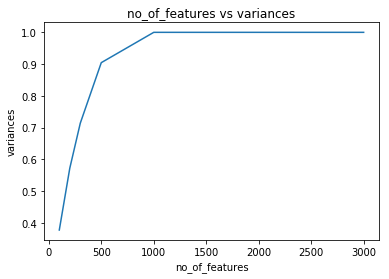

In [41]:
svd = TruncatedSVD(n_components=3000, n_iter=7, random_state=42)
s=svd.fit_transform(training_set_transformed)
no_of_features=np.array([100,200,300,500,1000,1500,2000,3000])
variances=[]
for i in no_of_features:
    variances.append(np.sum(svd.explained_variance_ratio_[:i])) 

plt.plot(no_of_features,variances)
plt.xlabel("no_of_features")
plt.ylabel("variances")
plt.title("no_of_features vs variances")

#variance with 300 features
np.sum(svd.explained_variance_ratio_[:300])

300 features give us 39% of information

In [42]:
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
final_counts=svd.fit_transform(training_set_transformed)
final_counts=preprocessing.scale(final_counts)

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(final_counts, i) for i in range(final_counts.shape[1])]
sorted_vif=sorted(vif)
no_duplicates=set(sorted_vif)
for i in no_duplicates:
    if i >5 :
         np.delete(final_counts,vif.index(i),axis=1)

In [45]:
#final_counts=preprocessing.scale(final_counts)
x_test=tf_idf_vect.transform(x_test)
x_test=svd.transform(x_test)
x_test=preprocessing.scale(x_test)

In [46]:
#Logistic Regression with 3 fold CV with GridSearch and Randomized Search
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
custom_scorer=make_scorer(f1_score,pos_label="positive")


In [47]:
#Using GridSearchCV and L2 regularization
model = GridSearchCV(LogisticRegression(class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["tfIdf","Logistic Regression GridSearchCV","L2",model.best_params_["C"],model.score(x_test, y_test)])



LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.927536231884058


In [48]:
#Using GridSearchCV and L1 regularization
model = GridSearchCV(LogisticRegression(penalty='l1',class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["tfIdf","Logistic Regression GridSearchCV","L1",model.best_params_["C"],model.score(x_test, y_test)])


LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.940754039497307


In [49]:
#Using RandomizedSearchCV and L2 regularization
tuned_parameters = {"C": stats.uniform(2, 10)}
custom_scorer=make_scorer(f1_score,pos_label="positive")

model = RandomizedSearchCV(LogisticRegression(class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))

x.add_row(["tfIdf","Logistic Regression RandomizedSearchCV","L2",model.best_params_["C"],model.score(x_test, y_test)])



LogisticRegression(C=10.819461240611332, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.927536231884058


In [50]:
#Using RandomizedSearchCV and L1 regularization
model = RandomizedSearchCV(LogisticRegression(penalty='l1',class_weight='balanced'), tuned_parameters,n_jobs=1, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))

x.add_row(["tfIdf","Logistic Regression RandomizedSearchCV","L1",model.best_params_["C"],model.score(x_test, y_test)])


LogisticRegression(C=6.368753080918899, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9405405405405404


In [51]:

clf = LogisticRegression(C=1, penalty='l1');
clf.fit(final_counts, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

print(clf.score(x_test, y_test))

163
0.9066666666666666


In [52]:

clf = LogisticRegression(C=0.5, penalty='l1');
clf.fit(final_counts, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

153
0.9033333333333333


In [54]:

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(final_counts, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

56
0.9333333333333333


In [55]:

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(final_counts, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

0
0.93


In [56]:
# Train your own Word2Vec model using your own text corpus
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(cleaned_text,score,test_size=0.3,random_state=0)

i=0
list_of_sent=[]
for sent in x_tr:
    list_of_sent.append(sent.split())


In [70]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
#w2v_model=model.fit(list_of_sent, total_examples=len(list_of_sent), epochs=10)


#model.build_vocab(list_of_sent)
#w2v_model=w2v_vec.train(list_of_sent)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

final_counts=sent_vectors

#final_counts=preprocessing.scale(final_counts)
#x_test=model.transform(x_test)

x_test=preprocessing.scale(x_test)


In [73]:
#Logistic Regression with 3 fold CV with GridSearch and Randomized Search
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
custom_scorer=make_scorer(f1_score,pos_label="positive")


#Using GridSearchCV and L2 regularization
model = GridSearchCV(LogisticRegression(class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["avgWord2Vec","Logistic Regression GridSearchCV","L2",model.best_params_["C"],model.score(x_test, y_test)])




LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


ValueError: could not convert string to float: 'get crazi realli imposs today find french vhs version film could pleas tell someth tks'

In [72]:

#Logistic Regression with 3 fold CV with GridSearch and Randomized Search
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
custom_scorer=make_scorer(f1_score,pos_label="positive")


#Using GridSearchCV and L2 regularization
model = GridSearchCV(LogisticRegression(class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["avgWord2Vec","Logistic Regression GridSearchCV","L2",model.best_params_["C"],model.score(x_test, y_test)])





#Using GridSearchCV and L1 regularization
model = GridSearchCV(LogisticRegression(penalty='l1',class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["avgWord2Vec","Logistic Regression GridSearchCV","L2",model.best_params_["C"],model.score(x_test, y_test)])



#Using RandomizedSearchCV and L2 regularization
tuned_parameters = {"C": stats.uniform(2, 10)}
custom_scorer=make_scorer(f1_score,pos_label="positive")

model = RandomizedSearchCV(LogisticRegression(class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["avgWord2Vec","Logistic Regression RandomizedSearchCV","L2",model.best_params_["C"],model.score(x_test, y_test)])






#Using RandomizedSearchCV and L1 regularization
model = RandomizedSearchCV(LogisticRegression(penalty='l1',class_weight='balanced'), tuned_parameters,n_jobs=1, scoring = custom_scorer, cv=3)
model.fit(final_counts, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["avgWord2Vec","Logistic Regression RandomizedSearchCV","L1",model.best_params_["C"],model.score(x_test, y_test)])





clf = LogisticRegression(C=1, penalty='l1');
clf.fit(final_counts, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

print(clf.score(x_test, y_test))

clf = LogisticRegression(C=1, penalty='l1');
clf.fit(final_counts, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

print(clf.score(x_test, y_test))



clf = LogisticRegression(C=0.5, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

clf = LogisticRegression(C=0.5, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))



clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))



clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))


ValueError: could not convert string to float: 'ive weight train year time use everi major brand protein supplement meal supplement ea myoplex whey nitrotech optimum whey design gnc etc labrada continu favorit far flavor vanilla tast good better protein powder ive chocol mediocr quit good myoplex banana flavor well might want pass one person recommend would get vanilla add small amount chocol strawberri syrup banana peanut butter flavor becom bore mix easili put shaker cup toss bowl cereal breakfast meal replac doesnt contain addit vitamin miner like myoplex proplet wouldnt recommend complet meal replac least take multivit plus side keep carb calori relat low consum protein brand deliv around protein calori carb whether bodi actual use protein one dose still debat sinc relat high dose protein assum your consum scoop per day would strong recommend consum half gallon water day minim strain put kidney'

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in clean_reviews['CleanedText'].values:
    list_of_sent.append(sent.split())

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() 
final_tf_idf = tf_idf_vect.fit_transform(clean_reviews['CleanedText'].values)
tfidf_sent_vectors = []; 
row=0;
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf =final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

final_counts=tfidf_sent_vectors

In [ ]:

#Logistic Regression with 3 fold CV with GridSearch and Randomized Search
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(final_counts,score,test_size=0.3,random_state=0)
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
custom_scorer=make_scorer(f1_score,pos_label="positive")



#Using GridSearchCV and L2 regularization
model = GridSearchCV(LogisticRegression(class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(x_tr, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["avgWord2Vec-tfIdf","Logistic Regression GridSearchCV","L2",model.best_params_["C"],model.score(x_test, y_test)])


#Using GridSearchCV and L1 regularization
model = GridSearchCV(LogisticRegression(penalty='l1',class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(x_tr, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["avgWord2Vec-tfIdf","Logistic Regression GridSearchCV","L1",model.best_params_["C"],model.score(x_test, y_test)])



#Using RandomizedSearchCV and L2 regularization
tuned_parameters = {"C": stats.uniform(2, 10)}
custom_scorer=make_scorer(f1_score,pos_label="positive")

model = RandomizedSearchCV(LogisticRegression(class_weight='balanced'), tuned_parameters, scoring = custom_scorer, cv=3)
model.fit(x_tr, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["avgWord2Vec-tfIdf","Logistic Regression RandomizedSearchCV","L2",model.best_params_["C"],model.score(x_test, y_test)])




#Using RandomizedSearchCV and L1 regularization
model = RandomizedSearchCV(LogisticRegression(penalty='l1',class_weight='balanced'), tuned_parameters,n_jobs=1, scoring = custom_scorer, cv=3)
model.fit(x_tr, y_tr)

print(model.best_estimator_)
print(model.score(x_test, y_test))
x.add_row(["avgWord2Vec-tfIdf","Logistic Regression RandomizedSearchCV","L1",model.best_params_["C"],model.score(x_test, y_test)])




clf = LogisticRegression(C=1, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

print(clf.score(x_test, y_test))

clf = LogisticRegression(C=1, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

print(clf.score(x_test, y_test))



clf = LogisticRegression(C=0.5, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

clf = LogisticRegression(C=0.5, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))



clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))



clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(x_tr, y_tr);
w = clf.coef_
print(np.count_nonzero(w))
print(clf.score(x_test, y_test))


In [ ]:
print (x)